In [60]:
import torch
from torch.utils.data import Dataset
import pandas as pd
class CoordDataset(Dataset):
    def __init__(self):
        df = pd.read_csv("coord_dataset.csv")
        self.X = torch.tensor(df.to_numpy()[:, 1:-1], dtype=torch.float32)
        self.y = torch.tensor(df.to_numpy()[:, -1], dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
dataset = CoordDataset()
dataset.X.shape, dataset.y.shape

(torch.Size([3544, 36]), torch.Size([3544]))

In [61]:
torch.manual_seed(42)
train, val, test = torch.utils.data.random_split(dataset, [0.6, 0.2, 0.2])

In [62]:
len(train), len(val), len(test)

(2127, 709, 708)

In [63]:
import torch.nn as nn

class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(36, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 8)
        )

    def forward(self, x):
        return self.net(x)
model = ClassificationNet()

In [59]:
from torch.utils.data import DataLoader
from tqdm import tqdm
EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
for epoch in (pbar := tqdm(range(EPOCHS))):
    for X, y in train_loader:
        model.zero_grad()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
    pbar.set_description(f"Epoch {epoch} -> Loss: {loss.item():.4f}")


Epoch 381 -> Loss: 0.0256:  38%|███▊      | 382/1000 [00:13<00:22, 27.53it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "model_state_dict.pt")

In [65]:
model = ClassificationNet()
model.load_state_dict(torch.load("model_state_dict.pt"))
model.eval()
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for X, y in train_loader:
        y_hat = model(X)
        _, predicted = torch.max(y_hat.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
accuracy = correct / total
print(f"Accuracy on train dataset: {accuracy:.2f}")


Accuracy on train dataset: 1.00


In [ ]:
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for X, y in val_loader:
        y_hat = model(X)
        _, predicted = torch.max(y_hat.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
accuracy = correct / total
print(f"Accuracy on val dataset: {accuracy:.2f}")


Accuracy on val dataset: 0.88


In [ ]:
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for X, y in test_loader:
        y_hat = model(X)
        _, predicted = torch.max(y_hat.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
accuracy = correct / total
print(f"Accuracy on test dataset: {accuracy:.2f}")


Accuracy on test dataset: 0.90


In [ ]:
import numpy as np
np.unique(dataset.y[val.indices], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([ 76, 226, 132,  73,  16,  14,  82,  90]))

In [ ]:
a = np.array([[1, 2, 3], [4, 5, 6]])
b = np.array([1, 2])
a / b[:, None]

array([[1. , 2. , 3. ],
       [2. , 2.5, 3. ]])

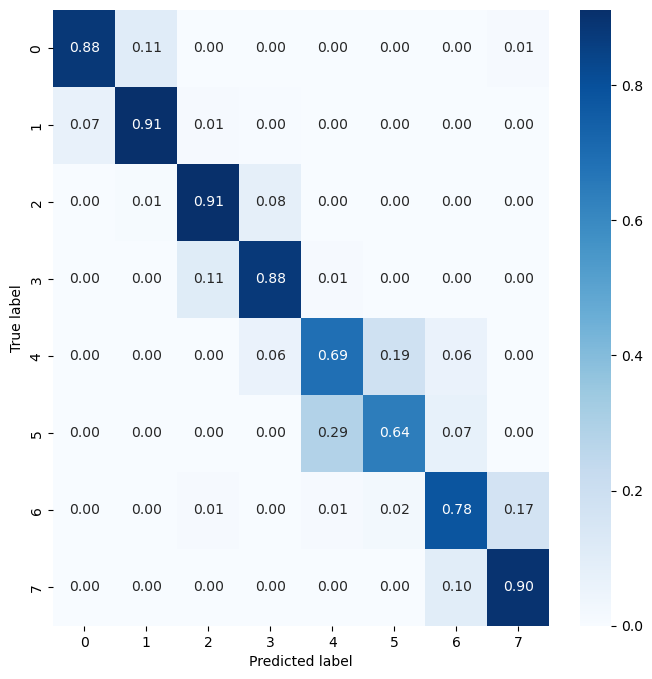

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# get predicted labels for val dataset
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)
y_true = []
y_pred = []
model = ClassificationNet()
model.load_state_dict(torch.load("model_state_dict.pt"))
model.eval()
for X, y in val_loader:
    y_hat = model(X)
    _, predicted = torch.max(y_hat.data, 1)
    y_true.extend(y.numpy())
    y_pred.extend(predicted.numpy())

# get confusion matrix
cm = confusion_matrix(y_true, y_pred)
value_counts = np.unique(dataset.y[val.indices], return_counts=True)[1]
cm = cm / value_counts[:, None]
# plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=range(8), yticklabels=range(8))
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
